In [3]:
%load_ext Cython
%load_ext autoreload

%autoreload 2

In [760]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from abc import ABC, abstractmethod,abstractproperty
from typing import Dict,Union,List,Optional,Tuple

In [208]:
# define abstract and custom class for data

from sklearn.preprocessing import LabelEncoder as LE
from scipy.spatial.distance import cdist

class DataSet(ABC):
    def __init__(self,
                 pth : str,
                )->None:
        
        
        self._data : pd.DataFrame = self._read_data(pth)
        
        self.N = self._data.shape[0]
        
        self.width : Optional[float] = None
        self.height : Optional[float] = None
            
        self.D : np.ndarray = self._get_weights()
            
        self.ranges : Dict[str,np.ndarray] = self._get_ranges()
        self.area : float = self._get_area()
            
        self.label_to_num : Union[None,LE] = None
            
        self.uni_types : np.ndarray = np.unique(self.types)
        
            
    @abstractmethod
    def _read_data(self,
                   pth : str,
                  )->pd.DataFrame:
        pass
        
    @abstractproperty
    def crd(self,)->np.ndarray:
        pass
    
    @abstractmethod
    def _get_area(self,
                  *args,
                  **kwargs,
                 )->float:
        pass
    
    @abstractmethod
    def _get_ranges(self,
                  )->Dict[str,np.ndarray]:
        pass
    
    @abstractproperty
    def types(self,)->np.ndarray:
        pass
    
    @property
    def numeric_types(self,
                     )->np.ndarray:
        if self.label_to_num is None:
            self.label_to_num = LE().fit(self.types)
        return self.label_to_num.transform(self.types)
    
    @abstractmethod
    def sample_crd(self,
                   npts : int,
                  )->np.ndarray:
        pass
    
    def _get_weights(self,
                    )->np.ndarray:
        
        return cdist(self.crd,
                     self.crd,
                     metric = "euclidean")
    
    
    def simulate(self,
                 npts : int,
                )->np.ndarray:
        
        npts = np.random.poisson(npts)
        crd = sample_crd(npts)
        
    def __getitem__(self,x)->pd.DataFrame:
        return self._data.iloc[x,:]
    
    def __len__(self,)->int:
        return self.N
        
    
class MerfishData(DataSet):
    def __init__(self,
                 data : pd.DataFrame,
                 type_colname : str = "types",
                )->None:
        
        super().__init__(data)
    
        self.type_colname = "types"
        
        
    def _read_data(self,
                   pth : str,
                  )->pd.DataFrame:
        
        return pd.read_csv(pth,
                          sep = ',',
                          header = 0,
                          index_col = 0,
                          )
        
    @property
    def crd(self,)->np.ndarray:
        return self._data[["x","y"]].values
    
    @property
    def types(self,
              )->np.ndarray:
        return self._data["types"].values
    
    def _get_ranges(self,
                   )->Dict[str,np.ndarray]:
        
            
        mxs = self.crd.max(axis =0)
        mns = self.crd.min(axis =0)
        
        _ranges = dict(x = np.array((mns[0],mxs[0])),
                       y = np.array((mns[1],mxs[1])),
                      )
        
        self.width = mxs[0] - mns[0]
        self.height = mxs[1] - mns[0]
                
        return _ranges
    
    def _get_area(self,
                 )->float:
        
        dx = self.ranges["x"][1]-self.ranges["x"][0]
        dy = self.ranges["y"][1]-self.ranges["y"][0]
        
        return dx*dy
    
    def sample_crd(self,
                  npts: int,
                  )->np.ndarray:
        
        xs = np.random.uniform(low = self.ranges["x"][0],
                               high = self.ranges["x"][1],
                               size = npts,
                              ).reshape(-1,1)
        
        ys = np.random.uniform(low = self.ranges["x"][0],
                               high = self.ranges["x"][1],
                               size = npts,
                              ).reshape(-1,1)
        
        return np.hstack((xs,ys))
    
        
        

In [209]:
# Load data

pths = {"slide_1":dict(path = "../../data/tomasso-team/merfish_new_seg.csv",
                       dataclass = MerfishData,
                      ),
       }

data = {k:v["dataclass"](v["path"]) for k,v in pths.items()}

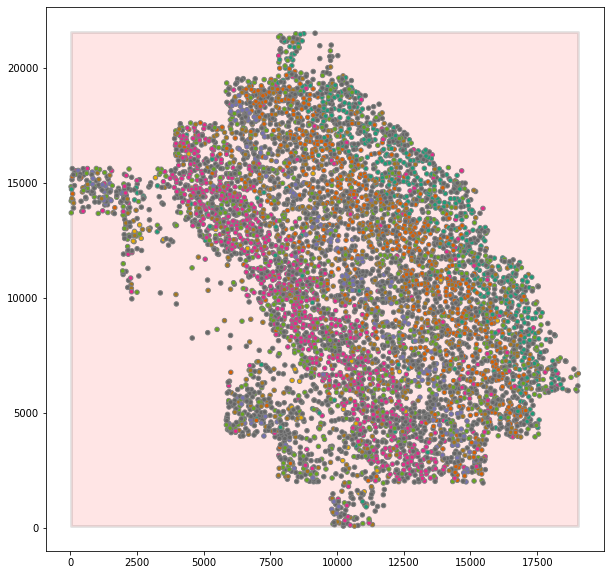

In [249]:
# check data
from sklearn import preprocessing
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

name = list(data.keys())[0]
fig,ax = plt.subplots(1,1, figsize = (10,10))
bounds = Rectangle((data[name].ranges["x"][0],
                   data[name].ranges["y"][0]),
                   data[name].width,
                   data[name].height,
                  )

pc = PatchCollection([bounds],
                     facecolor = "red",
                     alpha = 0.1,
                     edgecolor = "black",
                     linewidth = 3,
                     label = "bounding box"
                    )

bb = ax.add_collection(pc)
                     
ax.scatter(data[name].crd[:,0],
           data[name].crd[:,1],
           c = data[name].numeric_types,
           cmap = plt.cm.Dark2,
           s = 20,
           edgecolor = "gray",
           label = None,
        )


plt.show()

In [272]:
%%cython

from numpy cimport ndarray as ar

def K_t(double t,
        ar[double,ndim =2] D,
        double A,
         ):
    
    cdef double s  = 0.0
    cdef int i,j
    cdef int n_pts = D.shape[0]
    
    for i in range(n_pts-1):
        for j in range(i+1,n_pts):
            s += int(D[i,j] < t)
            
    s = s * A
    s = s / float(n_pts)**2
    
    return s*2.0
    

In [273]:
dists = np.linspace(data[name].D.min(),
                    data[name].D.max(),
                    1000)

unif = np.array([np.pi*(d**2) for d in dists])

vals = dict()

for tp in data[name].uni_types:
    
    pos = data[name].types == tp
    
    n_cells = pos.sum()

    val = [K_t(d,
               data[name].D[pos,:][:,pos],
               data[name].area) for d in dists ]

    val = np.array(val)
    
    vals.update({tp:val})


In [211]:
# generate confidence envelopes
envelope = False
if envelope:
    n_iter = 100
    sample_vals = list()
    for it in range(n_iter):
        _crd = data[name].sample_crd(n_cells)
        _D = cdist(_crd,_crd)
        _tmp = [K_t(d,
                _D,
                data[name].area,
                n_cells) for d in dists ]
        sample_vals.append(_tmp)

    sample_vals = np.array(sample_vals)

    envs = np.array(sample_vals)
    mx_envs = envs.max(axis = 0)
    mn_envs = envs.min(axis = 0)
    mean_envs = envs.mean(axis = 0)

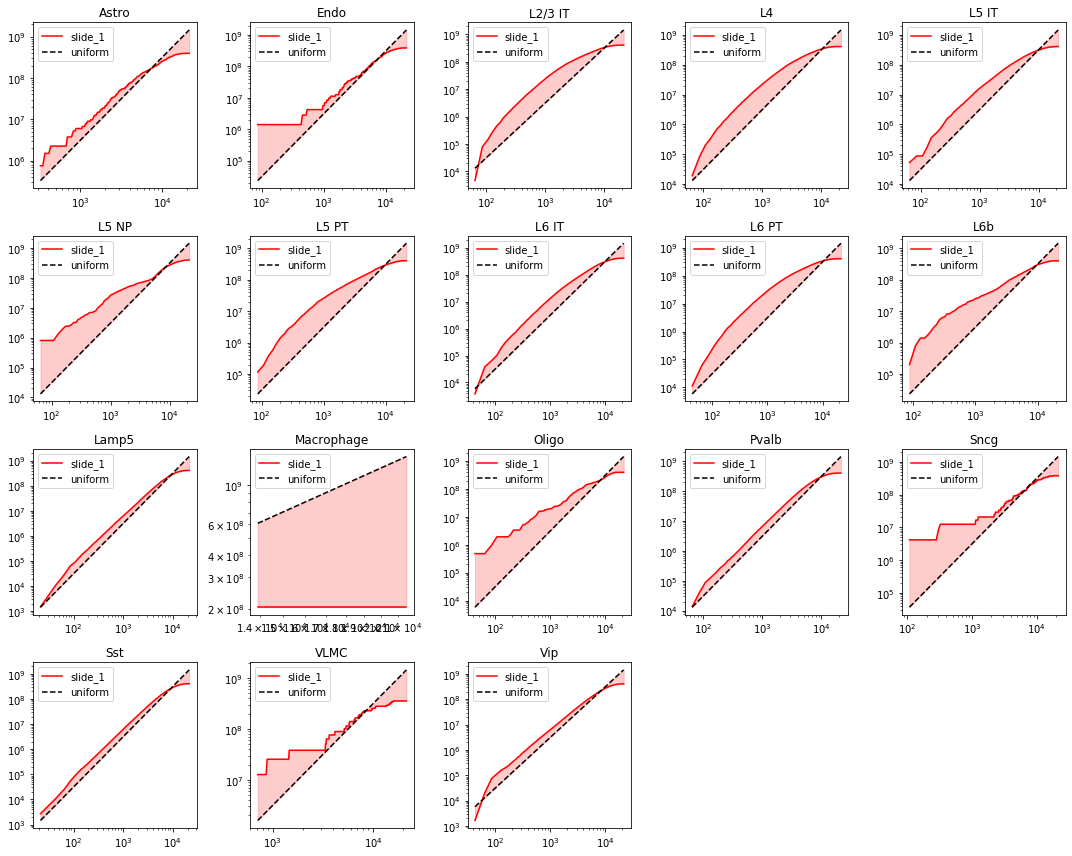

In [274]:
n_cols = 5
n_rows = int(np.ceil(len(data[name].uni_types) / n_cols))
side_size = 3

fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = (n_cols * side_size, n_rows * side_size))

ax = ax.flatten()

for k,tp in enumerate(vals.keys()):
    inc = vals[tp] > 0
    ax[k].plot(dists[inc],
               vals[tp][inc],
               color = "red",
               linestyle = "solid",
               label = name)
    
    ax[k].plot(dists[inc],
               unif[inc],
               color = "black",
               linestyle = "dashed",
               label = "uniform")
    
    ax[k].fill_between(dists[inc],
                       unif[inc],
                       vals[tp][inc],
                       color = "red",
                       alpha = 0.2,
                       label = None)

    
    ax[k].set_xscale("log")
    ax[k].set_yscale("log")
    ax[k].set_title(tp)
    ax[k].legend()

for k in range(len(vals),n_rows*n_cols):
    ax[k].set_visible(False)

fig.tight_layout()
plt.show()

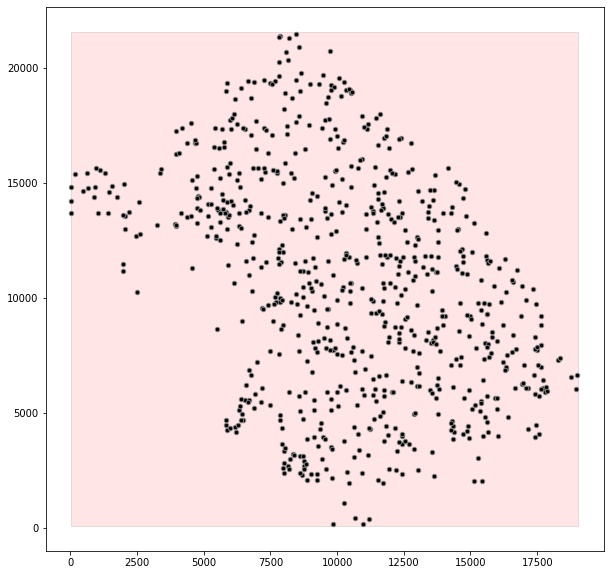

In [757]:
fig,ax = plt.subplots(1,1, figsize = (10,10))

tp = "Lamp5"
pos = data[name].types == tp

bounds = Rectangle((data[name].ranges["x"][0],
                   data[name].ranges["y"][0]),
                   data[name].width,
                   data[name].height,
                  )

pc = PatchCollection([bounds],
                     facecolor = "red",
                     alpha = 0.1,
                     edgecolor = "black")

ax.add_collection(pc)
                     
ax.scatter(data[name].crd[pos,0],
           data[name].crd[pos,1],
           c = "black",
           s = 20,
           edgecolor = "gray",
        )

plt.show()

In [665]:
%%cython
from numpy cimport ndarray as ar
from numpy cimport abs as abs




def PCF_r(double r,
          ar[double,ndim =2] D,
          double A,
          double h,
          )->float:
    
    def eh(double t)->float:
        cdef double kh
        kh =  3.0 / 4.0 / h * (1.0-(t/h)**2)
        return kh
    
    cdef double pi = 3.141592653589793
    cdef int n1 = D.shape[0]
    cdef int n2 = D.shape[1]
    cdef double s = 0    
    cdef double dr
    cdef int i,j
    
    for i in range(n1):
        for j in range(n2):
            dr = abs(D[i,j] - r)
            s += (eh(dr) if dr <= h else 0)
            
    s *= (A / (float(n1) * float(n2) * 2 * r * pi))
    return s



In [794]:
# Define function to generate synthetic data

def generate_pcf_synt(n_seeds : int,
                      radius : float = 5.0,
                      bw :  float = 1.0,
                      nn : int = 10,
                      crd_low : float = 0,
                      crd_high : float = 400,
                      seed : Optional[int] = None,
                     )->Tuple[np.ndarray,np.ndarray,np.ndarray,float]:
    
    if seed is not None:
        np.random.seed(seed)
    
    area = (crd_high-crd_low)**2

    crd_seed = np.random.uniform(low  = crd_low,
                                 high = crd_high,
                                 size = (n_seeds,2))

    crd_list = dict(seed = crd_seed,
                    crd_1 = [],
                    crd_2 = [])


    for crd,ref in zip(["crd_1","crd_2"],["seed","crd_1"]):
        for p in range(len(crd_list[ref])):
            
            center = crd_list[ref][p,:] 
            
            for n in range(int(np.random.uniform(1,nn))):
                
                r = np.random.uniform(radius - bw,radius + bw)
                
                theta = np.random.uniform(-np.pi,np.pi)
                
                _xy = np.array((r*np.cos(theta),r*np.sin(theta)))
                _xy = center + _xy
                
                crd_list[crd].append(_xy)

        crd_list[crd] = np.array(crd_list[crd])

    crd_1 = crd_list["crd_1"]
    crd_2 = crd_list["crd_2"]
    
    return (crd_1,crd_2,crd_seed,area)

In [799]:
# generate synthetic data
radius, bw = 10, 0.5
crd_1,crd_2,crd_seed,area = generate_pcf_synt(n_seeds=20,
                                              radius = radius,
                                              bw = bw,
                                              seed = 1337)

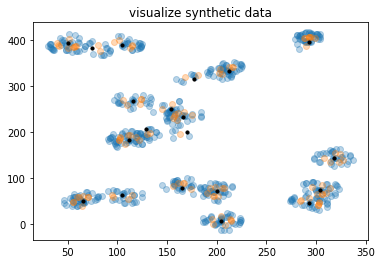

In [802]:
# visualize synhtetic data
fig,ax = plt.subplots(1,1)
ax.scatter(crd_2[:,0],
            crd_2[:,1],
            alpha = 0.3)

ax.scatter(crd_1[:,0],
            crd_1[:,1],
            alpha =0.3)

ax.scatter(crd_seed[:,0],
            crd_seed[:,1],
            s = 10,
            color ="black")

ax.set_title("visualize synthetic data")

plt.show()


In [806]:
# compute pcf over mulitple distances
t_dists = np.linspace(0.1,100,400)
t_D = cdist(crd_1,
            crd_2)
t_pcf = [PCF_r(r = r,
               D = t_D, 
               A = area,
               h = bw) for r in t_dists]


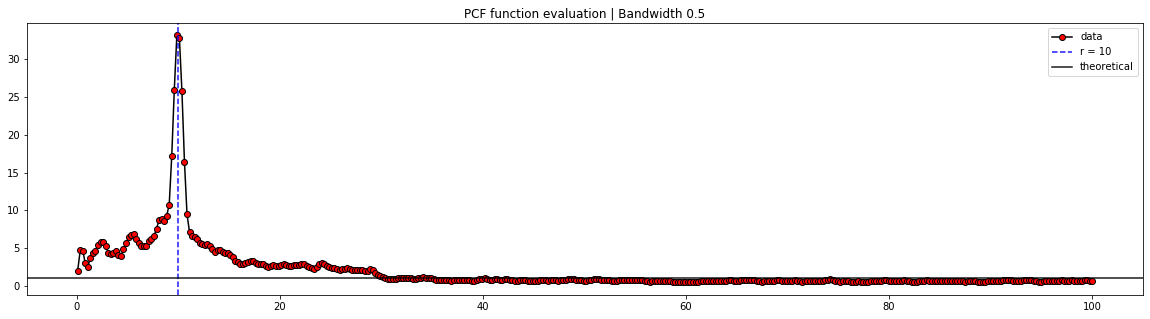

In [805]:
fig,ax = plt.subplots(1,1, figsize = (20,5))

ax.plot(t_dists,
        t_pcf,
        "-o",
        color = "black",
        markerfacecolor = "red",
        markeredgecolor = "black",
        label = "data",
       )

ax.axvline(x = radius,
            color = "blue",
            alpha = 0.9,
            linestyle = "dashed",
            label = "r = {}".format(radius),
            )

ax.axhline(y = 1,
            color = "black",
            alpha = 0.9,
            label = "theoretical"
           )

ax.legend()
ax.set_title("PCF function evaluation | Bandwidth {}".format(bw))

plt.show()
